### Access BoM Gridded rainfall data and save it as NetCDF files 

In [1]:
import datacube
import xarray as xr
import pandas as pd
%matplotlib inline
from datacube.storage.masking import mask_invalid_data
from datacube.storage.storage import write_dataset_to_netcdf

In [2]:
#app is a note to let GA know what we are doing with it, user-defined
#when loading data, #make sure data is on same coordinate scale or convert 
dc=datacube.Datacube(app='learn-data-access')
dc

Datacube<index=Index<db=PostgresDb<engine=Engine(postgresql://sl1412@130.56.244.105:6432/datacube)>>>

In [3]:
products = dc.list_products()
#products.columns.tolist()

In [4]:
display_columns = ['name', 'description', 'platform', 'product_type', 'instrument', 'crs', 'resolution']
#display_columns

In [5]:
# #list only nbar products
Rainfall_list = products[products['product_type'] == 'rainfall'][display_columns].dropna()
# productlist = products[display_columns].dropna()
Rainfall_list.describe

<bound method NDFrame.describe of                   name                                        description  \
id                                                                          
36  bom_rainfall_grids  Interpolated Rain Gauge Precipitation 1-Day Au...   

   platform product_type  instrument        crs     resolution  
id                                                              
36      BoM     rainfall  rain gauge  EPSG:4326  [-0.05, 0.05]  >

In [13]:
query = {
    'time': ('1960-01-01', '2013-12-31'),
    'lat': (-24.5, -38), # Bounding Lat
    'lon': (138.5, 152.5), # Bongding Long
}
#query = {
#    'time': ('2000-01-01', '2013-12-31'),
#    'geopolygon': geom,
# }

# attempt BoM rainfall 
#2 stars unpack the limits of our query, we load specific measurements from a product
Rainfall_data_long = dc.load(product='bom_rainfall_grids', measurements=['rainfall'], **query)

In [14]:
Rainfall_data_long

<xarray.Dataset>
Dimensions:    (latitude: 270, longitude: 280, time: 19723)
Coordinates:
  * time       (time) datetime64[ns] 1960-01-01 1960-01-02 1960-01-03 ...
  * latitude   (latitude) float64 -24.52 -24.57 -24.62 -24.67 -24.72 -24.77 ...
  * longitude  (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 138.8 ...
Data variables:
    rainfall   (time, latitude, longitude) float32 0.0 0.0 0.0 0.0 0.0 0.0 ...
Attributes:
    crs:      EPSG:4326

In [17]:
Rainfalldata = mask_invalid_data(Rainfall_data_long)
Rainfalldata.nbytes/10**9

5.964397384

In [18]:
from datacube.storage.storage import write_dataset_to_netcdf
# save daily rainfall to netcdf file 
path = '/g/data/oe9/project/team-drip/Rainfall/daily_rainfall_MDB_1960_2013.nc'
# Rainfalldata.to_netcdf(path)
write_dataset_to_netcdf(Rainfalldata,path)

In [22]:
#path = '/home/563/sl1412/rainfall/rainfallMDB2.nc'
# Rainfalldata.to_netcdf(path)

In [23]:
# Rainfalldata.assign_attrss(4326)

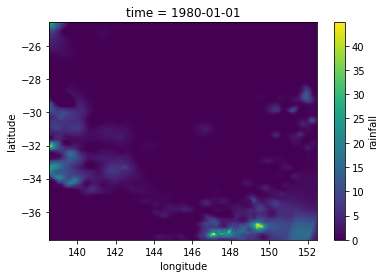

In [33]:
Rainfalldata.rainfall.isel(time=0).plot.imshow() # selection of time = 0 for all MDB

In [34]:
# calculate monthly rainfall 
Rainmonth=Rainfalldata.resample(time="1M").sum()

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/core/common.py:594: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  label=label, base=base)


In [37]:
Rainfalldata

<xarray.Dataset>
Dimensions:    (latitude: 263, longitude: 279, time: 12418)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 1980-01-03 ...
  * latitude   (latitude) float64 -24.57 -24.62 -24.68 -24.72 -24.77 -24.82 ...
  * longitude  (longitude) float64 138.6 138.6 138.7 138.7 138.8 138.8 138.9 ...
Data variables:
    rainfall   (time, latitude, longitude) float32 28.6986 27.4168 25.7257 ...
Attributes:
    crs:      EPSG:4326

In [42]:
attr = Rainfalldata.attrs
attr

OrderedDict([('crs', CRS('EPSG:4326'))])

In [54]:
Rainmonth.attrs = attr

Rainmonth

<xarray.Dataset>
Dimensions:    (latitude: 263, longitude: 279, time: 408)
Coordinates:
  * time       (time) datetime64[ns] 1980-01-31 1980-02-29 1980-03-31 ...
  * latitude   (latitude) float64 -24.57 -24.62 -24.68 -24.72 -24.77 -24.82 ...
  * longitude  (longitude) float64 138.6 138.6 138.7 138.7 138.8 138.8 138.9 ...
Data variables:
    rainfall   (time, latitude, longitude) float32 90.8184 88.6156 86.1563 ...
Attributes:
    crs:      EPSG:4326

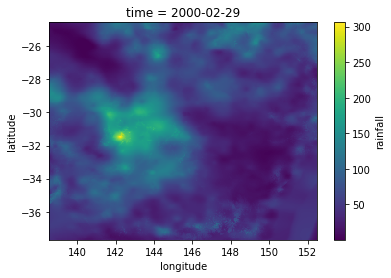

In [47]:
Rainmonth.rainfall.isel(time=1).plot.imshow() # selection of time = 1